In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pycountry_convert as pc
import os
import scipy.stats as stats
import pandas as pd
import plotly.express as px
import pandas
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
%matplotlib inline

## ```cyclists``` dataset

The dataset is used after it has undergone the phases of cleaning, feature engineering, and outlier detection.

In [2]:
cyclists_df = pd.read_csv('../dataset/cyclists_outlier.csv')

All columns present after cleaning, feature engineering, and outlier detection 

In [3]:
print(cyclists_df.columns)

Index(['_url', 'name', 'birth_year', 'nationality', 'cyclist_experience',
       'cyclist_win', 'cyclist_win_ratio', 'avg_relative_position',
       'relative_position_std', 'mean_last_10_positions',
       'min_relative_position', 'avg_performance_vs_startlist',
       'performance_entropy', 'weighted_podiums', 'career_level',
       'avg_position', 'best_position', 'best_position_std', 'top_experience',
       'continent', 'top_cyclists'],
      dtype='object')


Only numerical features are kept for k-means

In [4]:
numeric_columns = cyclists_df.select_dtypes(include=[np.number]).columns
print(numeric_columns)

Index(['birth_year', 'cyclist_experience', 'cyclist_win', 'cyclist_win_ratio',
       'avg_relative_position', 'relative_position_std',
       'mean_last_10_positions', 'min_relative_position',
       'avg_performance_vs_startlist', 'performance_entropy',
       'weighted_podiums', 'career_level', 'avg_position', 'best_position',
       'best_position_std'],
      dtype='object')


### **Clustering Preprocessing - Normalization**

#### **Decision of cyclists' features**
Feature decision is made among the numerical-only features 

In [5]:
# Specify the columns to keep
columns_to_keep = ["avg_relative_position", "career_level", "relative_position_std"] 
# new dataset with only the specified columns
all_cyclists_df = cyclists_df
cyclists_df = cyclists_df[columns_to_keep]

#### **Features normalization**


Standardize cyclists_df by scaling each feature to have a mean of 0 and a standard deviation of 1.

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
scaler.fit(cyclists_df)
cyclist_normalized_df = scaler.transform(cyclists_df)

pandas.DataFrame(scaler.inverse_transform(scaler.transform(cyclists_df)), columns=cyclists_df.columns)



,avg_relative_position,career_level,relative_position_std
0,0.456286,0.899462,0.243635
1,0.630686,-0.572894,0.205735
2,0.557360,-0.123706,0.219011
3,0.464642,-0.502688,0.238795
4,0.589817,-0.152291,0.238517
...,...,...,...
4140,0.510309,-0.496200,0.340690
4141,0.637519,-0.593160,0.215697
4142,0.697735,-0.600964,0.150866
4143,0.413682,-0.303189,0.238513


### **K-menas** of cyclists dataset 

#### **Best k**

In [7]:
k_grid = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]

sse_list = list()

label_list = []
dict_kmeans = {}
#search for the best k
for k in k_grid:

    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(cyclists_df)
    
    sse = kmeans.inertia_
    labels = kmeans.labels_
    #we save a list of see and labels for each k-means tried
    dict_kmeans[f'{k}_sse'] = sse
    dict_kmeans[f'{k}_labels'] = labels
    
    print(f'for k = {k}')
    print('SSE %s' % sse)
    # Use a smaller sample for Davies-Bouldin score calculation to avoid memory error
    sample_size = min(1000, len(cyclists_df))
    sample_indices = np.random.choice(len(cyclists_df), sample_size, replace=False)
    sample_df = cyclists_df.iloc[sample_indices]
    sample_labels = labels[sample_indices]
    current_bouldin = metrics.davies_bouldin_score(sample_df, sample_labels)
    dict_kmeans[f'{k}_bouldin_score'] = current_bouldin
    print('Separation %s' % current_bouldin)
    current_silhouette = silhouette_score(cyclists_df, labels)
    dict_kmeans[f'{k}_silhouette_score'] = current_silhouette
    print('Silhouette %s' % current_silhouette)
    

for k = 2
SSE 991.4362571070369
Separation 0.49332306644635027
Silhouette 0.7509816202093502
for k = 3
SSE 463.3739074572273
Separation 0.4860863382066564
Silhouette 0.6911080567099275
for k = 4
SSE 282.1437857907749
Separation 0.5283284356922754
Silhouette 0.6259500338309916
for k = 5
SSE 197.79424230740273
Separation 0.5592244974859872
Silhouette 0.5527109136789143
for k = 6
SSE 150.60983669657847
Separation 0.5685058279957013
Silhouette 0.5127491024882171
for k = 7
SSE 120.10157084413186
Separation 0.6173612794543571
Silhouette 0.4964609152812973
for k = 8
SSE 99.40403767544264
Separation 0.7040339636216494
Silhouette 0.40617557414230854
for k = 9
SSE 84.74948314087447
Separation 0.7020099648501463
Silhouette 0.38423473972322225
for k = 10
SSE 74.12531355481192
Separation 0.7032956146957048
Silhouette 0.3795166502621789
for k = 15
SSE 48.370473701284
Separation 0.777851895104366
Silhouette 0.3386530165222643
for k = 20
SSE 36.59794487929037
Separation 0.8492601090794261
Silhouette 0

**SSE plot**

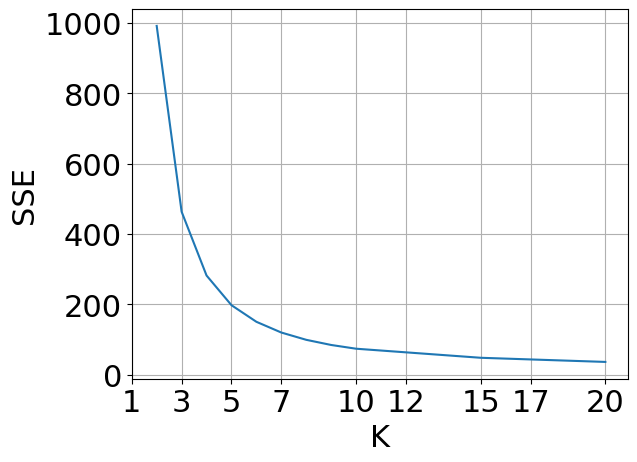

In [8]:
sse_list = [dict_kmeans[f'{k}_sse'] for k in k_grid]
plt.plot(k_grid, sse_list)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', labelsize=22)
plt.xticks([1, 3, 5, 7, 10, 12, 15, 17, 20])
plt.grid(True)
plt.show()


For K=3, appears to be the first point at which the rate of decrease in the curve decreases

**Silhouette plot**

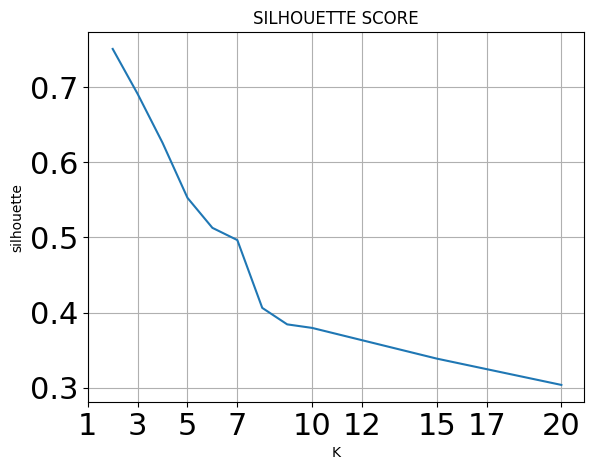

In [9]:
silhouette_list = [dict_kmeans[f'{k}_silhouette_score'] for k in k_grid]
plt.plot(k_grid, silhouette_list)
plt.ylabel('silhouette')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.title('SILHOUETTE SCORE')
plt.xticks([1, 3, 5, 7, 10, 12, 15, 17, 20])
plt.grid(True)
plt.show()

Silhouette reaches a maximum value near to k=3

**Dvies-Bouldin plot**

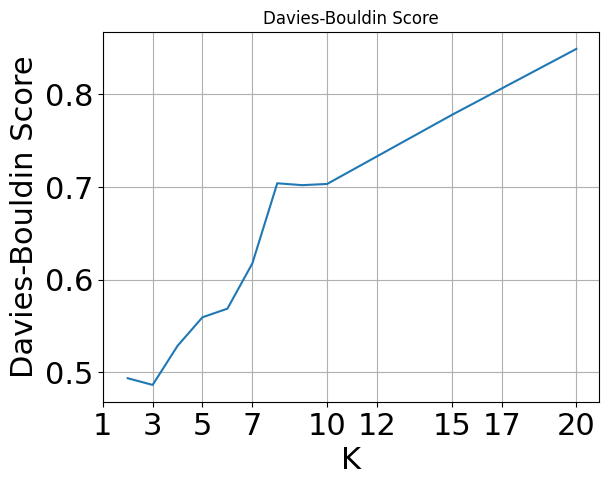

In [10]:
bouldin_list = [dict_kmeans[f'{k}_bouldin_score'] for k in k_grid]
plt.plot(k_grid, bouldin_list)
plt.ylabel('Davies-Bouldin Score', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', labelsize=22)
plt.title('Davies-Bouldin Score')
plt.xticks([1, 3, 5, 7, 10, 12, 15, 17, 20])
plt.grid(True)
plt.show()

In this case the best value is with k=3 

**Best k conclusion:**<br>
Considering the three metrics, the value of K=3 emerges as the best choice, as it represents a compromise that aligns well with all the evaluated metrics. 

#### **K-means resuslts** (cyclists dataset)


Considering the three metrics, the value of K=3 emerges as the best choice, as it represents a compromise that aligns well with all the evaluated metrics.

In [11]:
#RETRAIN BEST K-MEANS
best_k = 3
best_kmeans = KMeans(n_clusters=best_k, random_state=0, max_iter=1000)
best_kmeans.fit(cyclist_normalized_df)

KMeans(max_iter=1000, n_clusters=3, random_state=0)

In [12]:
# Calculate number of clusters for final kmeans
n_clusters = len(np.unique(best_kmeans.labels_))

# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(best_kmeans.labels_ == k))

print('cluster sizes:', occ_list)

cluster sizes: [1389, 2178, 578]


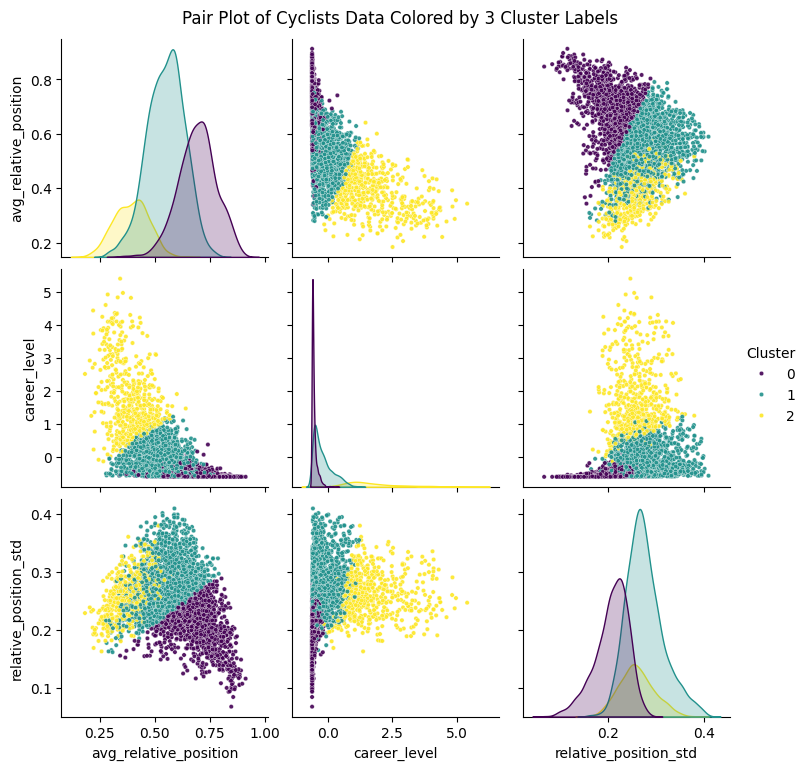

In [13]:
# convert lables to pandas Series
labels_series = pd.Series(best_kmeans.labels_, name='Cluster')

all_cyclists_df = all_cyclists_df.assign(Cluster=labels_series.values)

# Pair plot colored by cluster labels with smaller markers
sns.pairplot(cyclists_df.assign(Cluster=labels_series), hue='Cluster', palette='viridis', markers='o', plot_kws={'s': 10, 'alpha': 0.9})
plt.suptitle(f'Pair Plot of Cyclists Data Colored by {n_clusters} Cluster Labels', y=1.02)
plt.show()



Based on the pair plot the culstering result better is chosen 

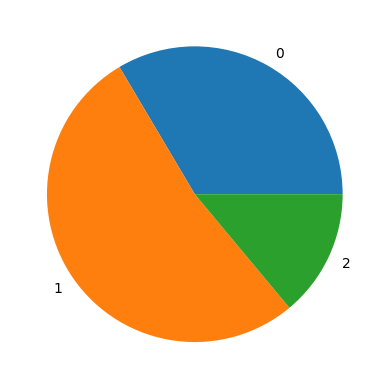

In [14]:
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show()

#### Characterization based on top cyclists column

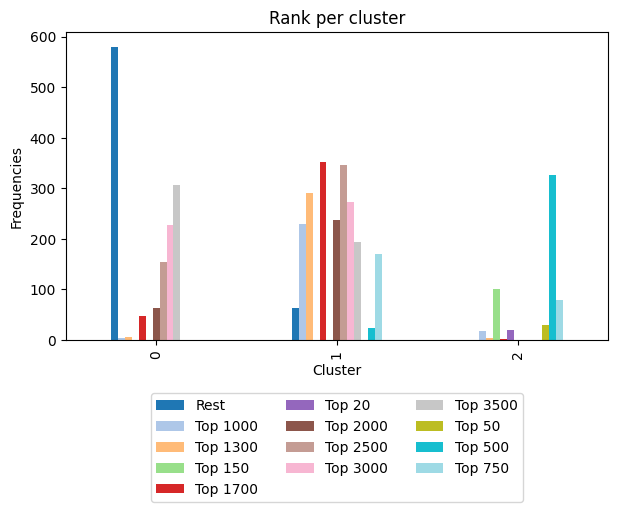

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize=(7, 4))

# Creare la tabella crosstab
rank_xt_pct = pd.crosstab(best_kmeans.labels_, all_cyclists_df['top_cyclists'])

# Tracciare il grafico con colori distinti
rank_xt_pct.plot(
    kind='bar', 
    stacked=False, 
    title='Rank per cluster', 
    ax=ax, 
    xlabel="Cluster", 
    ylabel="Frequencies", 
    colormap='tab20'  # Usa una colormap con almeno 11 colori distinti
)

# Posizionare la legenda sotto il grafico
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Mostrare il grafico
plt.show()


This plot shows, for each cluster, the number of cyclists belonging to that cluster who have a specific value for the feature "top_cyclist." This feature was created based on the "career_level" score: cyclists were ranked according to this score, and then different classes were created based on their position, such as top_20, top_50, and so on. <br>
The plot thus demonstrates that the clustering has grouped cyclists based on their career level, essentially reflecting how "strong" they were during their careers. By observing the different frequencies across clusters, it is evident that cluster 2 corresponds to the top cyclists, cluster 1 to intermediate-level cyclists, and cluster 0 to the remaining ones

**More precise visualization**

Starting from the plot shown above, the same analysis is now performed but with class divisions corresponding to the clustering results. The first class (representing the strongest cyclists) includes the top 578 cyclists, as the cluster identified as containing the best cyclists consists of 578 individuals, who ideally align with this category. The second class includes cyclists ranked from position 578 to 2756 (the next 2178 cyclists following the first category). Finally, the remaining cyclists, from position 2756 onward, form the third class

In [ ]:
# Sort the cyclists_df DataFrame by the 'career_level' column in descending order
sorted_cyclists_df = all_cyclists_df.sort_values(by='career_level', ascending=False)
[1389, 2178, 578]
# Define the bins and labels
bins = [0, 578, 2756, len(sorted_cyclists_df)]
labels = ['Top 578', 'Top 2756', 'Rest']

# Create a new column 'career_level_category' based on the bins
sorted_cyclists_df['top_cyclists2'] = pd.cut(range(1, len(sorted_cyclists_df) + 1), bins=bins, labels=labels, right=False)

# Add the 'top_cyclists' column to the original cyclists_df
all_cyclists_df = all_cyclists_df.merge(sorted_cyclists_df[['_url', 'top_cyclists2']], on='_url', how='left')

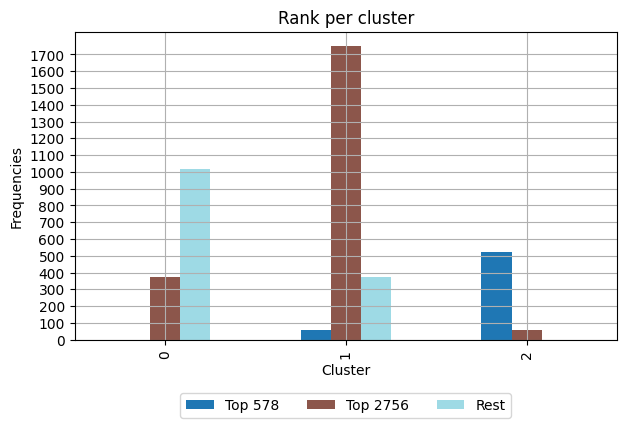

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize=(7, 4))

# Creare la tabella crosstab
rank_xt_pct = pd.crosstab(best_kmeans.labels_, all_cyclists_df['top_cyclists2'])

# Tracciare il grafico con colori distinti
rank_xt_pct.plot(
    kind='bar', 
    stacked=False, 
    title='Rank per cluster', 
    ax=ax, 
    xlabel="Cluster", 
    ylabel="Frequencies", 
    colormap='tab20'  # Usa una colormap con almeno 11 colori distinti
)

# Aggiungere più intervalli sull'asse y
ax.set_yticks(range(0, rank_xt_pct.values.max() + 1, 100))

# Aggiungere la griglia
ax.grid(True)

# Posizionare la legenda sotto il grafico
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Mostrare il grafico
plt.show()


Ideally, we would expect to see a single blue bar for cluster 2, a single brown bar for cluster 1, and a single light blue bar for cluster 0. While this is not exactly the case, we can still observe a trend that is close to the optimal scenario.

#### Radar plot

0
1
2


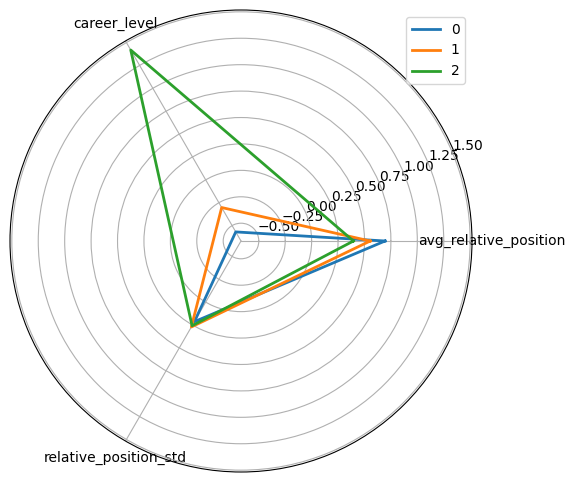

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import math

N = len(cyclists_df.columns)
plt.figure(figsize=(6, 6))

for k in range(0, n_clusters):
    print(k)
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
     
    values = cyclists_df[best_kmeans.labels_ == k].median().values.tolist()
    values += values[:1]
    angles += angles[:1]
    ax = plt.subplot(polar=True)
    plt.xticks(angles[:-1], cyclists_df.columns)
    ax.plot(angles, values, linewidth=2)


plt.legend(labels=np.unique(best_kmeans.labels_))

plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------

## ```races``` dataset

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pycountry_convert as pc
import os
import scipy.stats as stats
import pandas as pd
import plotly.express as px
import pandas
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
%matplotlib inline

The dataset is used after it has undergone the phases of cleaning, feature engineering, and outlier detection.

In [20]:
races_df = pd.read_csv('../dataset/races_outlier.csv')

### **Clustering Preprocessing - Normalization**

#### **Decision of rcaes features**
Feature decision is made among the numerical-only features 

In [21]:
# columns_preserve = ['startlist_quality', 'avg_cyclists_level', 'race_importance']     SIMONELLI
columns_preserve = ["climb_total", "length"]
all_races_df = races_df
# Create a new dataset with only the specified columns
races_df = races_df[columns_preserve]

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
scaler.fit(races_df)
races_normalized_df = scaler.transform(races_df)

pandas.DataFrame(scaler.inverse_transform(scaler.transform(races_df)), columns=races_df.columns)



,climb_total,length
0,3300.0,256500.0
1,3500.0,251800.0
2,3495.0,251400.0
3,3558.0,258000.0
4,3320.0,248700.0
...,...,...
2521,2978.0,187200.0
2522,4120.0,181200.0
2523,3359.0,190000.0
2524,3741.0,153400.0


### **K-means** for reaces dataset

### **Best K**

In [23]:
k_grid = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]

sse_list = list()

label_list = []
dict_kmeans = {}
#search for the best k
for k in k_grid:

    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(races_df)
    
    sse = kmeans.inertia_
    labels = kmeans.labels_
    #we save a list of see and labels for each k-means tried
    dict_kmeans[f'{k}_sse'] = sse
    dict_kmeans[f'{k}_labels'] = labels

    print(f'k: {k}, SSE: {sse}')

k: 2, SSE: 2575860493237.3667
k: 3, SSE: 1111589137164.0698
k: 4, SSE: 655760940608.4108
k: 5, SSE: 430616430607.67114
k: 6, SSE: 322091578944.5429
k: 7, SSE: 249594905690.15732
k: 8, SSE: 182410828422.0027
k: 9, SSE: 140893780134.12653
k: 10, SSE: 121522009283.93826
k: 15, SSE: 53396756550.56049
k: 20, SSE: 32076316264.701057


In [24]:
for k in k_grid:
    print(f'for k = {k}')
    
    print('SSE %s' % dict_kmeans[f'{k}_sse'])
    current_bouldin = metrics.davies_bouldin_score(races_df, dict_kmeans[f'{k}_labels'])
    dict_kmeans[f'{k}_bouldin_score'] = current_bouldin
    print('Separation %s' % current_bouldin)
    
    current_silhouette = silhouette_score(races_df, dict_kmeans[f'{k}_labels'])
    dict_kmeans[f'{k}_silhouette_score'] = current_silhouette
    print('Silhouette %s' % current_silhouette)

for k = 2
SSE 2575860493237.3667
Separation 0.3552180890622897
Silhouette 0.7367253209487536
for k = 3
SSE 1111589137164.0698
Separation 0.5100590197892536
Silhouette 0.5639562728687947
for k = 4
SSE 655760940608.4108
Separation 0.5083385264646565
Silhouette 0.5486757024292184
for k = 5
SSE 430616430607.67114
Separation 0.5063846166296809
Silhouette 0.5502364311576634
for k = 6
SSE 322091578944.5429
Separation 0.5024484070370588
Silhouette 0.5343525058240267
for k = 7
SSE 249594905690.15732
Separation 0.5309602916901033
Silhouette 0.5211020426321648
for k = 8
SSE 182410828422.0027
Separation 0.5161008857071353
Silhouette 0.5294987791537342
for k = 9
SSE 140893780134.12653
Separation 0.5138820730052496
Silhouette 0.5335590753125175
for k = 10
SSE 121522009283.93826
Separation 0.5350785757237435
Silhouette 0.5175714804848117
for k = 15
SSE 53396756550.56049
Separation 0.5138450351850653
Silhouette 0.5190745778839804
for k = 20
SSE 32076316264.701057
Separation 0.5321697016497835
Silhouet

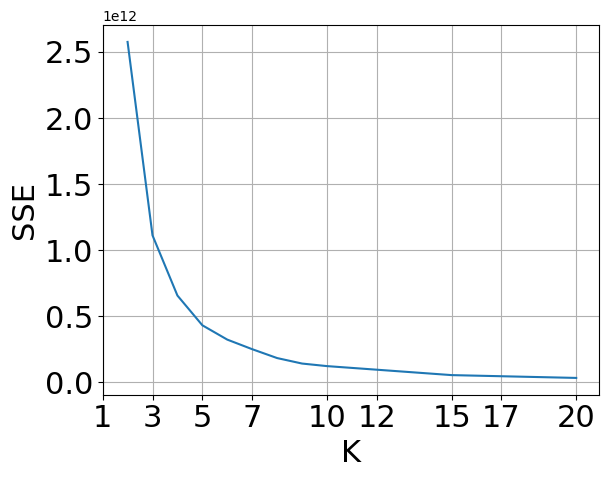

In [25]:
sse_list = [dict_kmeans[f'{k}_sse'] for k in k_grid]
plt.plot(k_grid, sse_list)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', labelsize=22)
plt.xticks([1, 3, 5, 7, 10, 12, 15, 17, 20])
plt.grid(True)
plt.show()


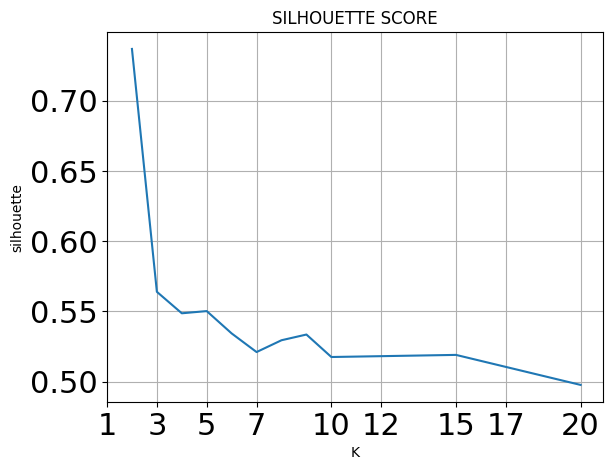

In [26]:
silhouette_list = [dict_kmeans[f'{k}_silhouette_score'] for k in k_grid]
plt.plot(k_grid, silhouette_list)
plt.ylabel('silhouette')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.title('SILHOUETTE SCORE')
plt.xticks([1, 3, 5, 7, 10, 12, 15, 17, 20])
plt.grid(True)
plt.show()

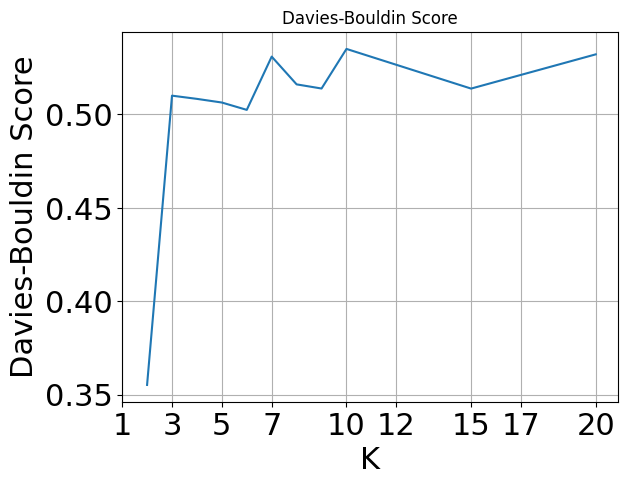

In [27]:
bouldin_list = [dict_kmeans[f'{k}_bouldin_score'] for k in k_grid]
plt.plot(k_grid, bouldin_list)
plt.ylabel('Davies-Bouldin Score', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', labelsize=22)
plt.title('Davies-Bouldin Score')
plt.xticks([1, 3, 5, 7, 10, 12, 15, 17, 20])
plt.grid(True)
plt.show()

### **K-means resuslts** (races datastet)

In [28]:
#RETRAIN BEST K-MEANS
best_k = 3
best_kmeans = KMeans(n_clusters=best_k, random_state=0, max_iter=1000)
best_kmeans.fit(races_normalized_df)

KMeans(max_iter=1000, n_clusters=3, random_state=0)

In [29]:
# Calculate number of clusters for final kmeans
n_clusters = len(np.unique(best_kmeans.labels_))

# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(best_kmeans.labels_ == k))

print('cluster sizes:', occ_list)

cluster sizes: [323, 1347, 856]


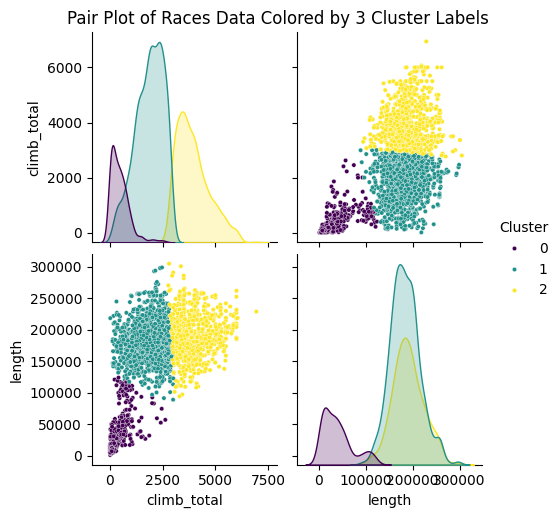

In [30]:
# convert lables to pandas Series
labels_series = pd.Series(best_kmeans.labels_, name='Cluster')

all_races_df = all_races_df.assign(Cluster=labels_series.values)

# Pair plot colored by cluster labels with smaller markers
sns.pairplot(races_df.assign(Cluster=labels_series), hue='Cluster', palette='viridis', markers='o', plot_kws={'s': 10, 'alpha': 1.0})
plt.suptitle(f'Pair Plot of Races Data Colored by {n_clusters} Cluster Labels', y=1.02)
plt.show()

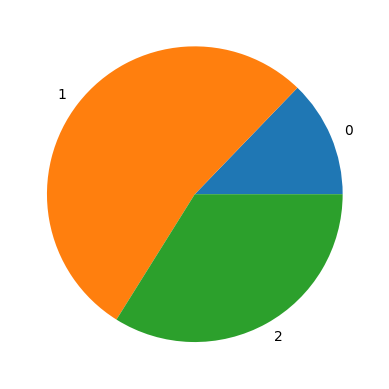

In [31]:
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show()

#### Characterization based on ```top_complex_races``` column

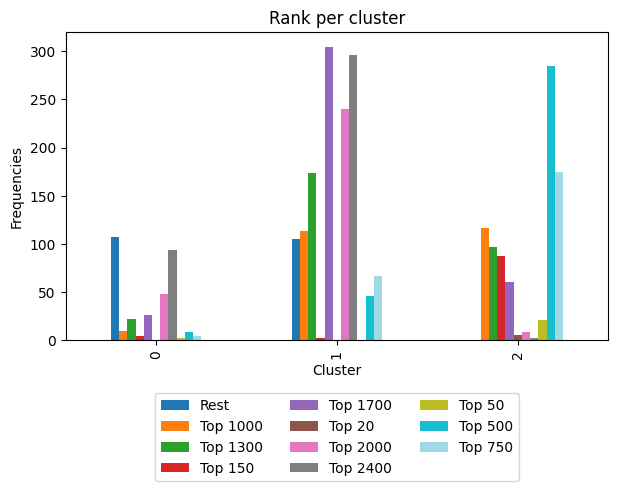

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize=(7, 4))

# Creare la tabella crosstab
rank_xt_pct = pd.crosstab(best_kmeans.labels_, all_races_df['top_complex_races_2'])

# Tracciare il grafico con colori distinti
rank_xt_pct.plot(
    kind='bar', 
    stacked=False, 
    title='Rank per cluster', 
    ax=ax, 
    xlabel="Cluster", 
    ylabel="Frequencies", 
    colormap='tab20'  # Usa una colormap con almeno 11 colori distinti
)

# Posizionare la legenda sotto il grafico
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Mostrare il grafico
plt.show()


**More precise visualization**

In [37]:
# Sort the cyclists_df DataFrame by the 'career_level' column in descending order
sorted_races_df = all_races_df.sort_values(by='race_importance', ascending=False)
[323, 1347, 856]
# Define the bins and labels
bins = [0, 856,  1179, len(sorted_races_df)]
labels = ['Top 856', 'Top 856-1179', 'Rest']

# Create a new column 'career_level_category' based on the bins
sorted_races_df['top_races2'] = pd.cut(range(1, len(sorted_races_df) + 1), bins=bins, labels=labels, right=False)

# Add the 'top_cyclists' column to the original cyclists_df
all_races_df = all_races_df.merge(sorted_races_df[['_url', 'top_races2']], on='_url', how='left')

all_races_df

,_url,name,points,length,climb_total,profile,startlist_quality,is_tarmac,start_date,duration,...,duration_to_length,real_name,startlist_entropy,points_entropy,difficulty_index_2,top_complex_races_2,Cluster,top_races2_x,top_races2_y,top_races2
0,amstel-gold-race/2012/result,Amstel Gold Race,225.0,256500.0,3300.0,2.0,1251,False,2012-04-15,06:32:35,...,0.0003,amstel-gold-race,3.459432,-0.000000,0.504047,Top 1300,2,Top 856,Top 856,Top 856
1,amstel-gold-race/2013/result,Amstel Gold Race,225.0,251800.0,3500.0,2.0,1149,False,2013-04-14,06:35:21,...,0.0003,amstel-gold-race,3.459432,-0.000000,0.543797,Top 1300,2,Top 856,Top 856,Top 856
2,amstel-gold-race/2014/result,Amstel Gold Race,225.0,251400.0,3495.0,2.0,1140,False,2014-04-20,06:25:57,...,0.0003,amstel-gold-race,3.459432,-0.000000,0.537071,Top 1300,2,Top 856,Top 856,Top 856
3,amstel-gold-race/2015/result,Amstel Gold Race,225.0,258000.0,3558.0,3.0,1175,False,2015-04-19,06:31:49,...,0.0003,amstel-gold-race,3.459432,-0.000000,0.821316,Top 1000,2,Top 856,Top 856,Top 856
4,amstel-gold-race/2016/result,Amstel Gold Race,225.0,248700.0,3320.0,2.0,1120,False,2016-04-17,06:18:03,...,0.0003,amstel-gold-race,3.459432,-0.000000,0.553074,Top 1300,2,Top 856,Top 856,Top 856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2521,vuelta-a-espana/2022/stage-5,La Vuelta ciclista a España,80.0,187200.0,2978.0,2.0,968,True,2022-08-24,04:15:23,...,0.0002,vuelta-a-espana,4.510788,0.057459,0.354556,Top 1700,2,Rest,Rest,Rest
2522,vuelta-a-espana/2022/stage-6,La Vuelta ciclista a España,80.0,181200.0,4120.0,5.0,968,True,2022-08-25,04:38:00,...,0.0003,vuelta-a-espana,4.510788,0.057459,1.298969,Top 500,2,Rest,Rest,Rest
2523,vuelta-a-espana/2022/stage-7,La Vuelta ciclista a España,80.0,190000.0,3359.0,2.0,968,True,2022-08-26,04:30:58,...,0.0002,vuelta-a-espana,4.510788,0.057459,0.363017,Top 1700,2,Rest,Rest,Rest
2524,vuelta-a-espana/2022/stage-8,La Vuelta ciclista a España,80.0,153400.0,3741.0,5.0,968,True,2022-08-27,04:05:25,...,0.0003,vuelta-a-espana,4.510788,0.057459,1.288190,Top 500,2,Rest,Rest,Rest


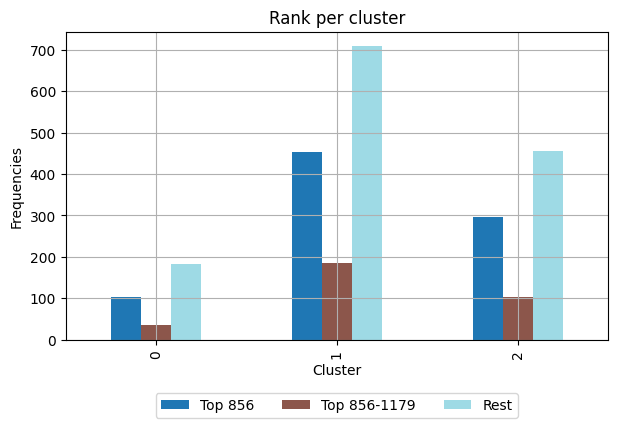

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize=(7, 4))

# Creare la tabella crosstab
rank_xt_pct = pd.crosstab(best_kmeans.labels_, all_races_df['top_races2'])

# Tracciare il grafico con colori distinti
rank_xt_pct.plot(
    kind='bar', 
    stacked=False, 
    title='Rank per cluster', 
    ax=ax, 
    xlabel="Cluster", 
    ylabel="Frequencies", 
    colormap='tab20'  # Usa una colormap con almeno 11 colori distinti
)

# Aggiungere più intervalli sull'asse y
ax.set_yticks(range(0, rank_xt_pct.values.max() + 1, 100))

# Aggiungere la griglia
ax.grid(True)

# Posizionare la legenda sotto il grafico
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Mostrare il grafico
plt.show()

## **TO DO** 

#### Radar plot

0
1
2


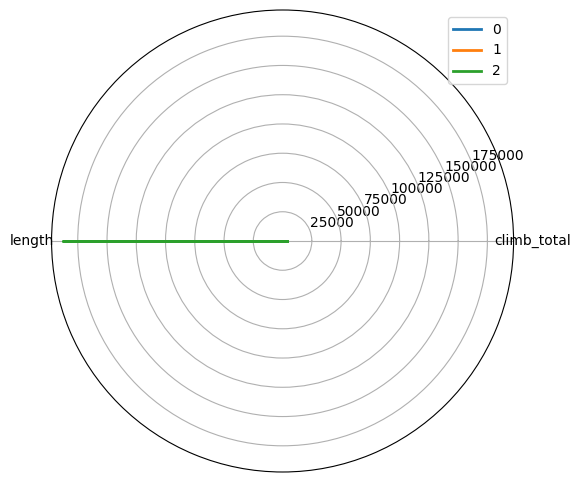

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

N = len(races_df.columns)
plt.figure(figsize=(6, 6))

for k in range(0, n_clusters):
    print(k)
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    values = races_df[best_kmeans.labels_ == k].median().values.tolist()
    values += values[:1]
    angles += angles[:1]
    ax = plt.subplot(polar=True)
    plt.xticks(angles[:-1], races_df.columns)
    ax.plot(angles, values, linewidth=2)


plt.legend(labels=np.unique(best_kmeans.labels_))

plt.show()